In [1]:
from segment_this_thing import Foveator, SegmentThisThingPredictor

foveation_pattern = Foveator(
    token_size=16, strides=[1, 2, 4, 6, 8], grid_sizes=[4, 4, 6, 8, 10]
)

In [2]:
from segment_this_thing import build_segment_this_thing_b

model = build_segment_this_thing_b(
    num_tokens=foveation_pattern.get_num_tokens(),
    token_size=16
)

In [3]:
# load model weights from 
import torch
model.load_state_dict(
    torch.load(
        "stt-b-qbkbmb5qsb4q2.pth",
        map_location="cpu"
    )
)

<All keys matched successfully>

In [4]:
predictor = SegmentThisThingPredictor(model, foveation_pattern)

/home/ianchuang/miniconda3/envs/gaze/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128062 (\N{PAW PRINTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


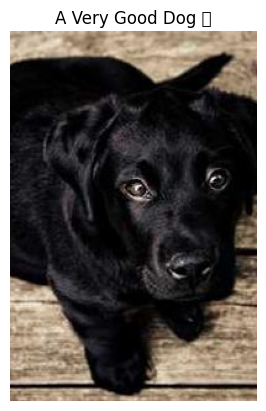

In [5]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Online dog image URL
url = "https://picsum.photos/id/237/200/300"  # You can change this to any other dog image URL

# Download image
response = requests.get(url)
if response.status_code == 200:
    image = Image.open(BytesIO(response.content))

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.title("A Very Good Dog 🐾")
    plt.show()
else:
    print("Failed to download image. Status code:", response.status_code)


In [42]:
import numpy as np
# convert to uint8 torch tensor
image = np.array(image).astype(np.uint8)
# convert to torch tensor
image = torch.from_numpy(image)

In [45]:
masks, ious, foveation = predictor.get_prediction(
    image, torch.tensor([0, 0]), return_foveation=True  
)

torch.Size([3, 172, 16, 16]) torch.Size([3])


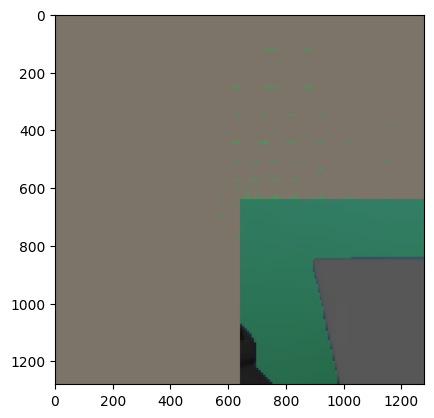

In [46]:

print(masks.shape, ious.shape)

k = ious.argmax().item()
ious = ious[k : k + 1]
masks = masks[k : k + 1]

num_masks = len(masks)
num_plots = 1 + num_masks


for k, (mask, iou) in enumerate(zip(masks, ious)):
    segmentation = foveation_pattern.generate_foveated_visualization(
        mask.unsqueeze(1)
    ).sigmoid()

    recon = foveation_pattern.generate_foveated_visualization(foveation)

    plt.imshow(
        torch.where(
            segmentation > 0.5,
            (
                0.5 * recon.float()
                + 0.5 * torch.tensor([0x32, 0xA8, 0x52]).view(3, 1, 1)
            ),
            recon,
        )
        .permute(1, 2, 0)
        .byte()
        .cpu()
        .numpy(),
    )


In [53]:
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from torch.utils.data import DataLoader
# create dataset
fps = 8.33333333333333
observation_indices = [0]
observation_timestamps = [i/fps for i in observation_indices]
delta_timestamps = {
    "observation.images.zed_cam_left": observation_timestamps,
    "left_eye": observation_timestamps,
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim_hook_package", 
    delta_timestamps=delta_timestamps,
)
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

In [54]:
batch = next(iter(dataloader))

In [55]:
from torch import nn, Tensor
import torch
from pathlib import Path
import os
import gaze_av_aloha
from segment_this_thing import build_segment_this_thing_b
from segment_this_thing import Foveator, SegmentThisThingPredictor
from torchvision.ops import roi_align


CACHE_DIR = Path(os.path.dirname(os.path.dirname(gaze_av_aloha.__file__))) / "cache"

import os
import requests
from tqdm import tqdm

from segment_this_thing.utils import (
    get_centered_crop,
    get_crop_bounds,
    get_imagenet_mean,
    get_imagenet_std,
)

def download_file(url: str, filename: str):
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            block_size = 1024  # 1 Kilobyte
            with open(filename, 'wb') as f, tqdm(
                total=total_size, unit='iB', unit_scale=True
            ) as bar:
                for data in response.iter_content(block_size):
                    f.write(data)
                    bar.update(len(data))
            print(f"Downloaded {filename}")
        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")


In [72]:
download_file(
    "https://huggingface.co/facebook/segment_this_thing/resolve/main/stt-b-qbkbmb5qsb4q2.pth",
    CACHE_DIR / "stt-b.pth"
)
stt = build_segment_this_thing_b(
    num_tokens=foveation_pattern.get_num_tokens(),
    token_size=16
)
stt.load_state_dict(
    torch.load(CACHE_DIR / "stt-b.pth", map_location="cpu")
)
model = stt.cuda()
foveator = Foveator(
    token_size=16, strides=[1, 2, 4, 6, 8], grid_sizes=[4, 4, 6, 8, 10]
).cuda()



In [85]:
from torchvision.transforms import Resize
import einops
import time

images = batch["observation.images.zed_cam_left"].cuda()
foveation_centers = batch["left_eye"].cuda().clone()
device = images.device

batch_size = images.shape[0]
images = einops.rearrange(
    images, "b t c h w -> (b t) c h w"
)
images = Resize((960, 1280))(images) 
images = (images.permute(0, 2, 3, 1) * 255.0).byte()  # Convert to uint8

print(images.shape)

foveation_centers = einops.rearrange(
    foveation_centers, "b t c -> (b t) c"
)
foveation_centers[...,0] = ((foveation_centers[...,0] + 1) / 2 * 1280)
foveation_centers[...,1] = ((foveation_centers[...,1] + 1) / 2 * 960)


start_time = time.perf_counter()
foveations = []
valid_token_masks = []
for i in range(batch_size):
    image = images[i]
    foveation_center = foveation_centers[i].to(torch.int32)

    crop_bounds = get_crop_bounds(
        foveation_center, foveator.get_pattern_bounds_size()
    ).to(device)
    crop = get_centered_crop(image, crop_bounds)

    valid_token_mask = foveator.get_in_bounds_tokens(
        torch.tensor(image.shape[1::-1], device=device), crop_bounds.to(device)
    )
    valid_token_masks.append(valid_token_mask)

    foveation = foveator.extract_foveated_image(
        crop.permute(2, 0, 1).to(device)
    )
    foveations.append(foveation)
foveations = torch.stack(foveations, dim=0)
valid_token_masks = torch.stack(valid_token_masks, dim=0)
print(f"Time taken to extract foveations: {time.perf_counter() - start_time:.2f} seconds")

masks, ious = model(
    (foveations - 255.0 * get_imagenet_mean(device).view(3, 1, 1))
    / (255.0 * get_imagenet_std(device).view(3, 1, 1)),
    valid_token_masks,
)
print(masks.shape, ious.shape)


torch.Size([64, 960, 1280, 3])
Time taken to extract foveations: 0.16 seconds
torch.Size([64, 3, 172, 16, 16]) torch.Size([64, 3])


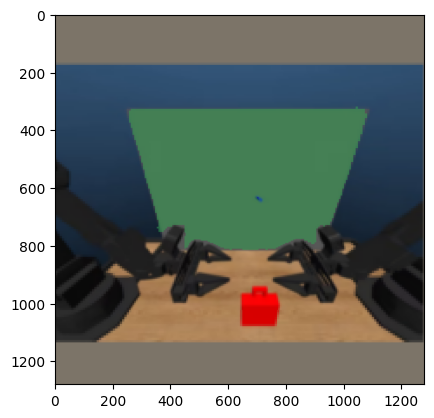

In [81]:

masks = masks[0]
ious = ious[0]
foveation = foveations[0]

k = ious.argmax().item()
ious = ious[k : k + 1]
masks = masks[k : k + 1]

num_masks = len(masks)
num_plots = 1 + num_masks


for k, (mask, iou) in enumerate(zip(masks, ious)):
    segmentation = foveation_pattern.generate_foveated_visualization(
        mask.unsqueeze(1)
    ).sigmoid()

    recon = foveation_pattern.generate_foveated_visualization(foveation)

    plt.imshow(
        torch.where(
            segmentation > 0.5,
            (
                0.5 * recon.float()
                + 0.5 * torch.tensor([0x32, 0xA8, 0x52]).view(3, 1, 1)
            ),
            recon,
        )
        .permute(1, 2, 0)
        .byte()
        .cpu()
        .numpy(),
    )


In [88]:
backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
backbone

Using cache found in /home/ianchuang/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [ ]:
import torch
import einops

x = torch.randn(1, 3, 224, 224)